In [2]:
import statsmodels as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_theme(style="darkgrid")

In [3]:
comp_prices_df = pd.read_csv("../data/comp_prices.csv")
sales_df = pd.read_csv("../data/sales.csv")


In [4]:
comp_prices_df.columns = list(map(str.lower, comp_prices_df.columns))
comp_prices_df["date_extraction"] = pd.to_datetime(comp_prices_df["date_extraction"])
comp_prices_df["date"] = pd.to_datetime(comp_prices_df["date_extraction"].dt.date)
comp_prices_df

,prod_id,date_extraction,competitor,competitor_price,pay_type,date
0,P6,2015-01-30 08:11:38,C3,1898.00,1,2015-01-30
1,P6,2015-01-30 08:11:38,C1,1898.00,1,2015-01-30
2,P6,2015-01-30 08:11:38,C6,1999.90,1,2015-01-30
3,P6,2015-01-31 20:10:14,C2,1894.88,2,2015-01-31
4,P6,2015-01-31 20:10:14,C3,1894.88,2,2015-01-31
...,...,...,...,...,...,...
50109,P5,2015-10-11 20:10:34,C1,819.00,2,2015-10-11
50110,P5,2015-10-11 20:10:34,C2,853.52,2,2015-10-11
50111,P5,2015-10-12 08:11:27,C2,853.52,1,2015-10-12
50112,P5,2015-10-12 08:11:27,C3,819.00,1,2015-10-12


In [5]:
sales_df.columns = list(map(str.lower, sales_df.columns))
sales_df["date_order"] = pd.to_datetime(sales_df.date_order)
sales_df["value_per_item"] = sales_df.revenue/sales_df.qty_order
sales_df

,prod_id,date_order,qty_order,revenue,value_per_item
0,P6,2015-08-02,1.0,1808.99,1808.99
1,P6,2015-08-17,1.0,1674.00,1674.00
2,P6,2015-08-17,1.0,1673.95,1673.95
3,P6,2015-08-11,1.0,1674.00,1674.00
4,P6,2015-08-17,1.0,1674.00,1674.00
...,...,...,...,...,...
351086,P3,2015-09-24,1.0,1008.83,1008.83
351087,P3,2015-10-13,2.0,2333.92,1166.96
351088,P3,2015-09-24,1.0,1311.81,1311.81
351089,P3,2015-10-13,1.0,1166.96,1166.96


In [17]:
df = pd.merge(sales_df.rename(columns={"date_order":"date"})\
             .groupby(["prod_id",
                            "date",
                            "value_per_item"])\
             .agg({"qty_order" : "sum"})\
             .reset_index(),
          comp_prices_df.groupby(["prod_id","date"])\
              .competitor_price.agg(["min","max","mean", "median"])\
              .reset_index(),
         on=["date", "prod_id"]
          )
df

,prod_id,date,value_per_item,qty_order,min,max,mean,median
0,P1,2015-03-15,1294.38,1.0,1499.0,1499.0,1499.0000,1499.00
1,P1,2015-03-15,1347.51,1.0,1499.0,1499.0,1499.0000,1499.00
2,P1,2015-03-15,1362.50,46.0,1499.0,1499.0,1499.0000,1499.00
3,P1,2015-03-16,1362.50,17.0,1362.5,1499.0,1464.2050,1499.00
4,P1,2015-03-16,1499.00,7.0,1362.5,1499.0,1464.2050,1499.00
...,...,...,...,...,...,...,...,...
9200,P9,2015-10-14,360.05,16.0,393.0,56900.0,10884.1095,399.99
9201,P9,2015-10-14,379.00,557.0,393.0,56900.0,10884.1095,399.99
9202,P9,2015-10-14,388.65,3.0,393.0,56900.0,10884.1095,399.99
9203,P9,2015-10-14,399.99,1.0,393.0,56900.0,10884.1095,399.99


In [18]:
day_agg = df.groupby(["prod_id", "date"])\
         .agg({"qty_order" : "sum"})\
         .rename(columns={"qty_order" : "qty_day"})\
         .reset_index()

df = pd.merge(df,
        day_agg,
        on=["prod_id", "date"])

day_agg_shift = day_agg
day_agg_shift["date"]  = day_agg_shift["date"].apply(lambda x: x + pd.Timedelta(days=7))
day_agg_shift.rename(columns={"qty_day": "qty_day_shift"}, inplace=True)
df = pd.merge(df,
              day_agg_shift,
        on=["prod_id", "date"])
#df["diff_min_pct"] = (df.value_per_item - df["min"])/df["min"]
df["diff_mean_pct"] = (df.value_per_item - df["mean"])/df["mean"]

In [14]:
df

,prod_id,date,value_per_item,qty_order,min,max,mean,median,qty_day,qty_day_shift,diff_min_pct,diff_mean_pct
0,P1,2015-03-22,1362.50,4.0,1424.05,1499.0,1488.292857,1499.000,7.0,48.0,-0.043222,-0.084522
1,P1,2015-03-22,1499.00,3.0,1424.05,1499.0,1488.292857,1499.000,7.0,48.0,0.052632,0.007194
2,P1,2015-03-23,1362.50,3.0,1403.90,1499.0,1456.487500,1461.525,6.0,24.0,-0.029489,-0.064530
3,P1,2015-03-23,1424.05,1.0,1403.90,1499.0,1456.487500,1461.525,6.0,24.0,0.014353,-0.022271
4,P1,2015-03-23,1499.00,2.0,1403.90,1499.0,1456.487500,1461.525,6.0,24.0,0.067740,0.029188
...,...,...,...,...,...,...,...,...,...,...,...,...
8928,P9,2015-10-14,360.05,16.0,393.00,56900.0,10884.109500,399.990,590.0,259.0,-0.083842,-0.966920
8929,P9,2015-10-14,379.00,557.0,393.00,56900.0,10884.109500,399.990,590.0,259.0,-0.035623,-0.965179
8930,P9,2015-10-14,388.65,3.0,393.00,56900.0,10884.109500,399.990,590.0,259.0,-0.011069,-0.964292
8931,P9,2015-10-14,399.99,1.0,393.00,56900.0,10884.109500,399.990,590.0,259.0,0.017786,-0.963250


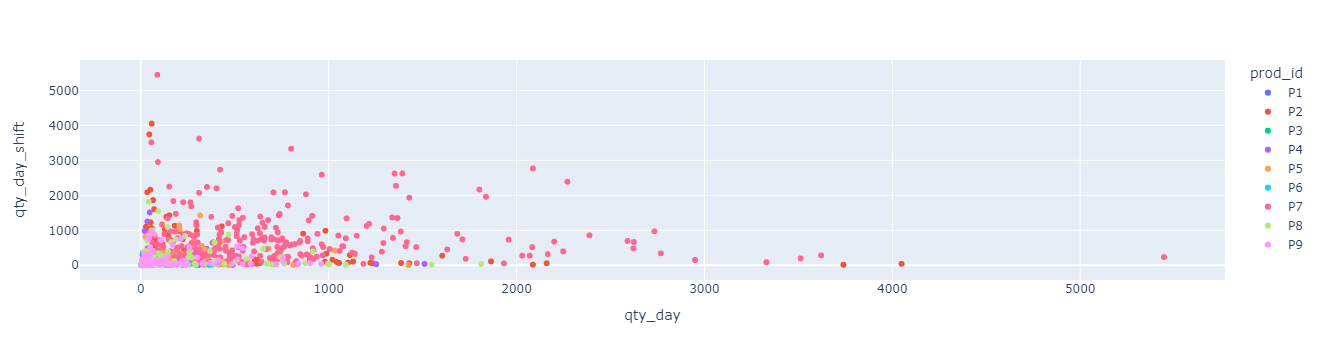

In [16]:
px.scatter(df, x="qty_day", y="qty_day_shift", color="prod_id")